# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
import os
file_path = os.path.abspath("Tennis_Linux/Tennis.x86_64")
env = UnityEnvironment(file_name=file_path, no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)

TennisBrain


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
print(states)
print(actions)

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677
[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         -6.14030886 -1.5        -0.          0.
  -7.11741829  6.         -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         -7.9574213  -1.5         0.          0.
   7.11741829  6.          0.          0.        ]]
[[-0.52742854 -0.72832315]
 [-0.34292251 -0.02658039]]


When finished, you can close the environment.

### 4. Training

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from collections import namedtuple, deque

#### Import MADDPG

The MADDPG contains two DDPG agents for rockets. During training, each agent receives centralized observations but makes actions based on local perspective. 

In [2]:
from agent import MADDPG

In [7]:
def train(agent, n_episodes=7000, max_t=1000, noise_decay=0.9997):
    """Deterministic Critic and Actor training.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        noise_decay(float): initial noise for decay
    """
    noise = 2
    noise_reduction = noise_decay
    scores_window = deque(maxlen=100)  
    scores_per_episode = [] 
    average_scores_list  = []

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations              # get the current state
        score = np.zeros(num_agents)
        agent.reset()
        for t in range(max_t):
            action = agent.act(state, noise)
            noise *= noise_reduction
            env_info   = env.step(action)[brain_name]   # send the action to the environment
            next_state = env_info.vector_observations   # get the next state
            reward     = env_info.rewards               # get the reward
            done       = env_info.local_done            # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if any(done):
                break
                
        score_max = np.max(score)
        scores_per_episode.append(score_max)
        scores_window.append(score_max)
        avg_score = np.mean(scores_window)
        average_scores_list.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.10f}'.format(i_episode,avg_score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.10f}, Noise: {:.10f}'.format(i_episode, avg_score, noise))
        if avg_score >=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.10f}'.format(i_episode-100, avg_score))
            torch.save(agent.maddpg_agent[0].actor.state_dict(), 'checkpoint_0.pth')
            torch.save(agent.maddpg_agent[1].actor.state_dict(), 'checkpoint_1.pth')
            
    return scores_per_episode, average_scores_list

In [3]:
def plot_scores(scores, filename=None, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.figure(figsize=(8.00,6.00))
    plt.plot(scores, color='b', linestyle='-', linewidth=0.75) 
    plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window, min_periods=1).mean()
    plt.plot(rolling_mean, color='r', linestyle='-', linewidth=0.75)
    if filename is not None:
        plt.savefig(filename)

#### Training MADDPG: Round I

Episode 100	Average Score: 0.0010000000, Noise: 1.2874726458
Episode 200	Average Score: 0.0110000002, Noise: 0.7932700785
Episode 300	Average Score: 0.0010000000, Noise: 0.5155834174
Episode 400	Average Score: 0.0000000000, Noise: 0.3367144346
Episode 500	Average Score: 0.0000000000, Noise: 0.2198996450
Episode 600	Average Score: 0.0000000000, Noise: 0.1436108729
Episode 700	Average Score: 0.0105000002, Noise: 0.0886179959
Episode 800	Average Score: 0.0100000001, Noise: 0.0542585922
Episode 900	Average Score: 0.0050000001, Noise: 0.0342433477
Episode 1000	Average Score: 0.0110000002, Noise: 0.0207597755
Episode 1100	Average Score: 0.0199000003, Noise: 0.0122097843
Episode 1200	Average Score: 0.0070000001, Noise: 0.0076390043
Episode 1300	Average Score: 0.0190000003, Noise: 0.0043300631
Episode 1400	Average Score: 0.0080000001, Noise: 0.0026156340
Episode 1500	Average Score: 0.0169000003, Noise: 0.0014706730
Episode 1600	Average Score: 0.0180000003, Noise: 0.0008005381
Episode 1700	Aver

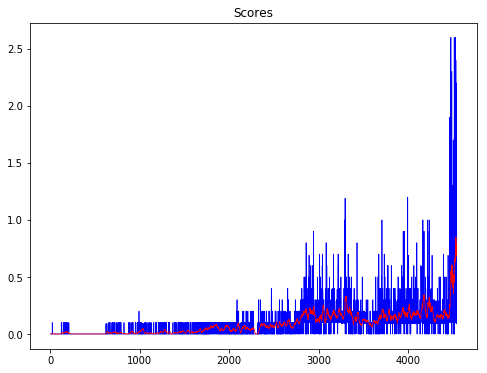

In [15]:
class Params:
    """Set up configuration here."""
    def __init__(self):
        self.__dict__.update(**{
            'buffer_size' : int(1e4),  # replay buffer size
            'batch_size'  : 256,       # minibatch size
            'gamma'       : 0.99,      # discount factor
            'tau'         : 1e-3,      # for soft update of target parameters
            'lr'          : 1e-4,      # learning rate 
            'update_every' : 1,        # how often to update the network
})
        
device = torch.device("cpu")

params = Params()

agent = MADDPG(state_size=state_size, action_size=action_size, params=params, device=device)
scores_all, scores_avg = train(agent, n_episodes=5000)

plot_scores(scores=scores_all, rolling_window=20)

#### Training MADDPG: Round II

Note: the result of this section can be found in **./checkpoint**

In [ ]:
class Params:
    """Set up configuration here."""
    def __init__(self):
        self.__dict__.update(**{
            'buffer_size' : int(1e4),  # replay buffer size
            'batch_size'  : 256,       # minibatch size
            'gamma'       : 0.99,      # discount factor
            'tau'         : 1e-3,      # for soft update of target parameters
            'lr'          : 1e-4,      # learning rate 
            'update_every' : 1,        # how often to update the network
})
        
device = torch.device("cpu")

params = Params()

agent = MADDPG(state_size=state_size, action_size=action_size, params=params, device=device)
scores_all, scores_avg = train(agent, n_episodes=7000)

plot_scores(scores=scores_all, rolling_window=20)

Episode 100	Average Score: 0.0049000001, Noise: 1.2452995599
Episode 200	Average Score: 0.0060000001, Noise: 0.7901818878
Episode 300	Average Score: 0.0000000000, Noise: 0.5182200060
Episode 400	Average Score: 0.0069000001, Noise: 0.3232509882
Episode 500	Average Score: 0.0060000001, Noise: 0.2030920564
Episode 600	Average Score: 0.0099000002, Noise: 0.1252844675
Episode 700	Average Score: 0.0296000005, Noise: 0.0663199974
Episode 800	Average Score: 0.0428000006, Noise: 0.0343565544
Episode 900	Average Score: 0.0437000007, Noise: 0.0173343519
Episode 1000	Average Score: 0.0188000003, Noise: 0.0102073776
Episode 1100	Average Score: 0.0230000004, Noise: 0.0058522564
Episode 1200	Average Score: 0.0430000008, Noise: 0.0030072542
Episode 1300	Average Score: 0.0451000007, Noise: 0.0015342267
Episode 1400	Average Score: 0.0533000009, Noise: 0.0007458120
Episode 1500	Average Score: 0.0721000011, Noise: 0.0003179982
Episode 1600	Average Score: 0.0955000014, Noise: 0.0001017150
Episode 1700	Aver

### 5. Conclusion

1. This task can be solved without collaboration between agents.
2. As the result, the elapsed time for solving the problem is uncertain. For example, Round I takes more than 4000 epiodes to achieve 0.5 over 100 episodes. However, Round II requires 2000 only and even reaches 0.86 within 2500 episodes.
3. When more experiments token, sometime the agent stunts at exploitation phase, and fails to achieve the goal.
4. The design of model is critical. So far, it's unclear how a normalization layer affects the stability of training. The other issue is the the environment introducing redundant dimentions.

### 6. Future work

1. Try different exploration approaches
2. Prioritized memory buffer